# <center>Practical 10: Articulated Robots - Kinematics</center>

<p style="color:#0000FF";> <b>Let us first make sure that all the required dependencies are installed</b></p> 


## 1. Install dependencies
### In your local machine
1. Open Anaconda prompt
2. Type ``pip install ansitable``

### In AWS
1. Add and execute the following line at the beginning of your notebook
```python 
%cd Support/robotics-toolbox-python
%env CFLAGS='-std=c99'
import sys
!{sys.executable} -m pip install --upgrade setuptools
!{sys.executable} -m pip install ansitable
!{sys.executable} -m pip install -e .
%cd ../..```

## 2. Setup Robotics Toolboox
### In your local machine
1. If not already installed, install [Visual Studio Build Tools](https://visualstudio.microsoft.com/thank-you-downloading-visual-studio/?sku=BuildTools&rel=15). Select the options shown in the image below

<img src="Support/images/Capture.PNG" width="700" height="700" align="center">

2. After installing Visual Studio Build Tools, open File Explorer and go to the folder in which you cloned the Practicals repository
3. Using the right click, select ``Git Bash Here``
4. Type ``git submodule update --init --recursive``
5. Open Anaconda prompt
6. Type ``cd Week10/Support/robotics-toolbox-python``
7. Type ``pip3 install --upgrade pip setuptools``
8. Type ``pip3 install -e . ``

In [1]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
%matplotlib notebook

import roboticstoolbox as rtb
from roboticstoolbox import DHRobot, RevoluteDH
from spatialmath import SE3, SO3
from spatialmath.base.transforms3d import tr2delta
import numpy as np
import math

import sys
import os
sys.path.insert(0, os.path.abspath('Support'))

from visualizer import *

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# 1. 2-Dof Planar Manipulator

Let us start with the definition of simple 2-dof planar manipulator as shown in the image below

<img src="Support/images/2-linkrobot.png" width="400" height="400" align="center">

**Interaction**
- Change the value of each slider and see how the configuration of our articulated robot changes
- The homogeneous transform shown in the plot indicates the orientation and location of the end effector in the world frame

<IPython.core.display.Javascript object>


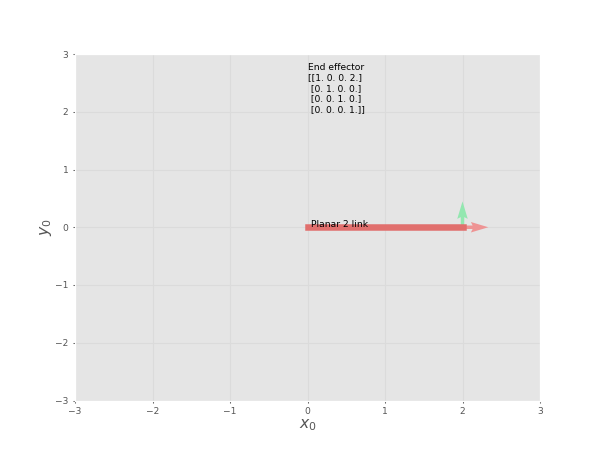

In [3]:
# Create manipulator
bot = rtb.models.DH.Planar2()

# Create visualization context
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim(-3.0, 3.0)
ax.set_ylim(-3.0, 3.0)
ax.set_xlabel(r'$x_0$', fontsize=12)
ax.set_ylabel(r'$y_0$', fontsize=12)

# Create visualizer instance
my_plot = RobotJupyterPlot(bot, ax, readonly=True)

# Plot robot
my_plot.draw2()

# Callback method associated to slider events
def rotate(theta1, theta2):
    """
    Apply new joint configuration (theta1, theta2) as defined by slider
    :param theta1 (float): Joint angle (in degrees) of first revolute joint 
    :param theta2 (float): Joint angle (in degrees) of second revolute joint
    """
    # Assign angles to robot
    bot.q = [np.deg2rad(theta1), np.deg2rad(theta2)]
    # Plot robo
    my_plot.draw2()
    
    
def reset(b):
    """
    Set sliders and robot back to default values
    """
    bot.q = [0, 0]
    my_plot.draw2()
    theta1_slider.value = 0
    theta2_slider.value = 0

# Create interaction sliders and reset button
theta1_slider = widgets.FloatSlider(value=0, min=-90, max=90, step=1, description=r'$\theta_1$ (deg)',
                                    continuous_update=True)
theta2_slider = widgets.FloatSlider(value=0, min=-90, max=90, step=1, description=r'$\theta_2$ (deg)',
                                    continuous_update=True)

btn_reset = widgets.Button(description='Reset', disabled=False, button_style='success')
btn_reset.on_click(reset)

# Define display layout, link slider to rotate method and show plot
ui = widgets.HBox([widgets.VBox([theta1_slider, theta2_slider]), btn_reset])
out = widgets.interactive_output(rotate, {'theta1': theta1_slider, 'theta2':theta2_slider})
display(ui)

# 2. Forward Kinematics

How can we determine the position and orientation of the end effector $H_{0n}$ given the joint configuration $[\theta_1, \theta_2]$ of our robot?

From the lecture slides, recall $T = \begin{bmatrix} R & \boldsymbol{d} \\ \boldsymbol{0} & 1 \end{bmatrix}$. In our current model, the relative homogeneous transformation of each link is defined as 

\begin{equation*}
T_i(q_i) = \begin{bmatrix} R_z(q_i) & \boldsymbol{0}^T \\ \boldsymbol{0} & 1 \end{bmatrix} *\begin{bmatrix} I(3) & [L_i, 0, 0]^T \\ \boldsymbol{0} & 1 \end{bmatrix} ,
\end{equation*}

where $q_i = \theta_i$ and $L_i = 1$ corresponds to the length of each link and $I(3)$ indicates an identity matrix of dimensions 3x3.

To determine the position and orientation of the end effector we need to combine all transformations according to $H_{0n} = T_1(q_1)T_2(q_2)\dots T_n(q_n)$

Let's now see how we can do this. We will use the objects ``SE3.Rx(angle)``,  ``SE3.Ry(angle)``, ``SE3.Rz(angle)`` to define pure rotations, and ``SE3(x,y,z)`` to define pure translations. 

**TODO**:
1. Given $[\theta_1, \theta_2]$ and $[l1, l2]$ build the homogenous transformation of each link
2. Combine all transformation to obtain $H_{0n}$. Homogeneous matrices can be combined using the ``*`` operator, i.e., ``T1 = SE3.Rz() * SE3(1, 0, 0)``

In [4]:
def compute_forward_kinematics_2dof_manipulator(robot):
    # Get current joint angles
    thetas = robot.q
    link_lengths = robot.a
    
    # Define end effector transformation
    H_n0 = SE3()
    
    # TODO 1: Compute transformation for first link
    # Elementary rotation about z -> SE3.Rz (as you can see we rotate about the z axes)
    T_01 = SE3.Rz(thetas[0])*SE3(link_lengths[0],0,0)
    # TODO 2: Compute transformation for first link
    T_12 = SE3.Rz(thetas[1])*SE3(link_lengths[1],0,0)
    
    # TODO 3: Combine all transformations
    H_0n = T_01*T_12
        
    return H_0n

### Check our solution

First, let's compare our method to the output provided by the robotics toolbox library (``fkine(.)`` method)

In [15]:
# Assign a configuration to the robot
bot.q = [np.deg2rad(90), np.deg2rad(45)]

# Print solution as given by the library
#print("Solution from library:\n{}".format(bot.fkine()))

# Print solution as given by our method
#print("Solution from our method:\n{}".format(compute_forward_kinematics_2dof_manipulator(bot)))


Next, let's visualize the manipulator and compare our output with the matrix shown in the figure below

<IPython.core.display.Javascript object>


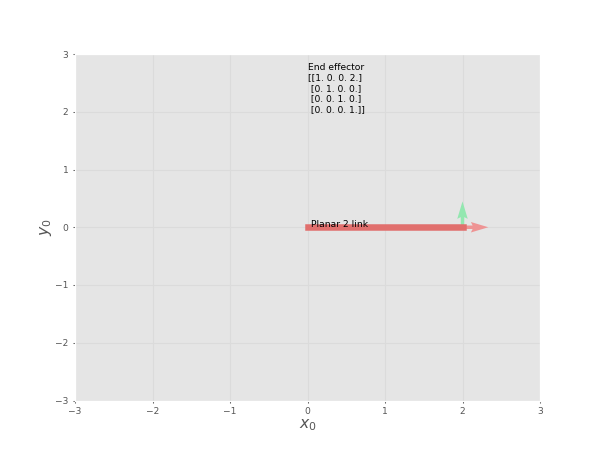

In [16]:
# Create manipulator
bot = rtb.models.DH.Planar2()

# Create visualization context
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim(-3.0, 3.0)
ax.set_ylim(-3.0, 3.0)
ax.set_xlabel(r'$x_0$', fontsize=12)
ax.set_ylabel(r'$y_0$', fontsize=12)

# Create visualizer instance
my_plot = RobotJupyterPlot(bot, ax, readonly=True)

# Plot robot
my_plot.draw2()


# Callback method associated to slider events
def rotate(theta1, theta2):
    """
    Apply new joint configuration (theta1, theta2) as defined by slider
    :param theta1 (float): Joint angle (in degrees) of first revolute joint
    :param theta2 (float): Joint angle (in degrees) of second revolute joint
    """
    # Assign angles to robot
    bot.q = [np.deg2rad(theta1), np.deg2rad(theta2)]
    # Plot robo
    my_plot.draw2()
    
    
def reset(b):
    """
    Set sliders and robot back to default values
    """
    bot.q = [0, 0]
    my_plot.draw2()
    theta1_slider.value = 0
    theta2_slider.value = 0

# Create interaction sliders and reset button
theta1_slider = widgets.FloatSlider(value=0, min=-90, max=90, step=1, description=r'$\theta_1$ (deg)',
                                    continuous_update=True)
theta2_slider = widgets.FloatSlider(value=0, min=-90, max=90, step=1, description=r'$\theta_2$ (deg)',
                                    continuous_update=True)

btn_reset = widgets.Button(description='Reset', disabled=False, button_style='success')
btn_reset.on_click(reset)

# Define display layout, link slider to rotate method and show plot
ui = widgets.HBox([widgets.VBox([theta1_slider, theta2_slider]), btn_reset])
out = widgets.interactive_output(rotate, {'theta1': theta1_slider, 'theta2':theta2_slider})
display(ui)

**FLUX Question**: What is the location of the end effector in the world frame when we set $\theta_1=90$ and $\theta_2=45$?

# 3. DH Pameters

Let us now look at the definition of a robotic manipulator using the Denavit-Hartenberg convention. 

Given a robot object, we can display its parameters by using ``print(bot)``. Let's see the DH parameters of our 2-dof manipulator

In [17]:
#print(bot)

## 3.1 DH Parameters of a 3-dof manipulator

Given the image below, define the DH parameters for a 3-dof manipulator

<img src="Support/images/3dof-linkrobot.png" width="400" height="400" align="center">


This manipulator consists of 3 revolute joints. To define a revolute joint, we use the class ``RevoluteDH`` with attributes:
- ``d``: link offset
- ``a``: link length
- ``alpha``: link twist

Similarly, to define a manipulator, we instantiate an object of type ``DHRobot`` and specify as parameter a list with all ``RevoluteDH`` joints and a name.

**TODO**: Specify the DH parameters for the 3dof manipulator shown above. ``RevoluteDH`` expects angles to be specified in radians. You can use ``np.deg2rad()`` to convert degrees to radians

In [18]:
# TODO: Define d, a, and alpha for all links
link1 = RevoluteDH(d=1, a=0, alpha=np.pi/2)
link2 = RevoluteDH(d=0, a=1, alpha=0)
link3 = RevoluteDH(d=0, a=1, alpha=0)

my_bot = DHRobot([link1, link2, link3], name='3dof-manipulator')

Let us visualize our 3dof manipulator

<IPython.core.display.Javascript object>


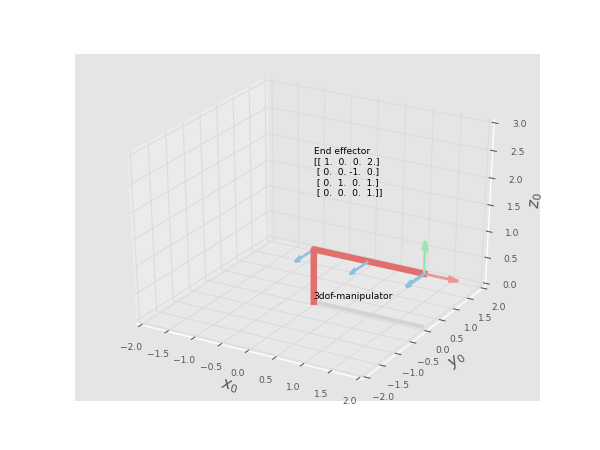

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim3d(-2.0, 2.0)
ax.set_ylim3d(-2.0, 2.0)
ax.set_zlim3d(0.0, 3.0)
ax.set_xlabel(r'$x_0$', fontsize=12)
ax.set_ylabel(r'$y_0$', fontsize=12)
ax.set_zlabel(r'$z_0$', fontsize=12)

my_plot = RobotJupyterPlot(my_bot, ax, readonly=True)
my_plot.draw()


def rotate(theta1, theta2, theta3):
    """
    Apply new joint configuration (theta1, theta2, theta3) as defined by slider
    :param theta1 (float): Joint angle (in degrees) of first revolute joint
    :param theta2 (float): Joint angle (in degrees) of second revolute joint
    :param theta3 (float): Joint angle (in degrees) of third revolute joint
    """
    my_bot.q = [np.deg2rad(theta1), np.deg2rad(theta2), np.deg2rad(theta3)]
    my_plot.draw()
    
    
def reset(b):
    """
    Set sliders and robot back to default values
    """
    my_bot.q = [0, 0, 0]
    my_plot.draw()
    theta1_slider.value = 0
    theta2_slider.value = 0
    theta3_slider.value = 0
    
    
theta1_slider = widgets.FloatSlider(value=0, min=-90, max=90, step=.1, description=r'$\theta_1$ (deg)',
                                    continuous_update=True)
theta2_slider = widgets.FloatSlider(value=0, min=-90, max=90, step=.1, description=r'$\theta_2$ (deg)',
                                    continuous_update=True)
theta3_slider = widgets.FloatSlider(value=0, min=-90, max=90, step=.1, description=r'$\theta_3$ (deg)',
                                    continuous_update=True)


btn_reset = widgets.Button(description='Reset', disabled=False, button_style='success')
btn_reset.on_click(reset)

# Define display layout, link slider to rotate method and show plot
ui = widgets.HBox([widgets.VBox([theta1_slider, theta2_slider, theta3_slider]), btn_reset])
out = widgets.interactive_output(rotate, {'theta1': theta1_slider, 
                                          'theta2': theta2_slider,
                                          'theta3': theta3_slider})
display(ui)

**Flux Question**: What is the orientation of the end-effector when $\theta_1 = 90$, $\theta_2 = 0$ and $\theta_3 = 90$?

# 4. Jacobian Matrix 3-Dof Manipulator

The Jacobian matrix of a manipulator is defined as

\begin{equation}
J = 
\begin{bmatrix}
\boldsymbol{z}^0_0 \times \boldsymbol{d}^0_{0e} & \cdots & {z}^0_{n-1} \times \boldsymbol{d}^0_{n-1e}\\
\boldsymbol{z}^0_0 & \dots & \boldsymbol{z}^0_{n-1}
\end{bmatrix}
\end{equation}

where $\boldsymbol{z}^0_{i-1}$ corresponds to the axis of the $i$-th joint and $\boldsymbol{d}^0_{i-1e}$ defines the vector pointing from the $i$-th joint to the end-effector; both given in world coordinates.

Thus, in order to compute the Jacobian for our 3dof manipulator:
1. Compute forward kinematics for all links (we will use ``fkine_all(.)``) to do so
2. Find $\boldsymbol{z}^0_{i-1}$ and $\boldsymbol{d}^0_{i-1e}$ for all joints (recall that all joints in our manipulator are revolute joints along the z-axis)
    - To access the axis of a joint, use T.a
    - To access the position of a joint, use T.t
3. Form the Jacobian according to the equation provided above

**TODO**: Complete the missing steps
1. Compute the vector pointing from the $i$-th joint to the end-effector $\boldsymbol{d}^0_{i-1e}$
2. Compute the cross product between the axis of the $i$-th joint $\boldsymbol{z}^0_{i-1}$ and $\boldsymbol{d}^0_{i-1e}$. Use the method ``np.cross(.)`` to do so.

In [20]:
def compute_jacobian(robot):
    """
    Compute jacobian matrix for a given robot configuration
    :param robot (DHRobot): Robot object for which Jacobian will be computed
    :return 6xn matrix: Jacobian matrix of dimensions 6 x num joints in robot
    """
    
    #Create an empty Jacobian matrix
    J = np.zeros((6, robot.n))
        
    # Compute forward dynamics
    T_all = robot.fkine_all()
    # Add base transform
    T_all.insert(0, robot.base)    
    
    #Get end-effector position in world coordinates
    end_effector_position = robot.fkine().t
    
    for i in range(robot.n):
        # Get joint axis (z-axis in our case)
        joint_axis = T_all[i].a
        
        # Get joint's position
        joint_position = T_all[i].t
        
        #TODO 1: Compute vector pointing from joint to end effector
        joint_to_end_effector = end_effector_position - joint_position
        
        #TODO 2: Compute cross product between joint_axis and d_ie
        cross_v = np.cross(joint_axis, joint_to_end_effector)
        
        # Assign entries to Jacobian matrix        
        J[:3,i] = cross_v
        J[3:, i] = joint_axis
        
    return J

Let's test our code

In [21]:
# Reset robot to default configuration
my_bot.q = [0, 0, 0]

# Let's compute the end effector linear and angular velocities when q = [0, 0 , 0] and dq = [0, 1, 0]
J = compute_jacobian(my_bot) 
dx = J @ np.array([0,1,0])

# Print Jacobian and velocity
#print("The Jacobian matrix is:\n{}\n".format(np.round(J, 6)))
#print("The end effector linear and angular velocites:\n{}".format(np.round(dx,4)))

**Flux Question**: What are the linear and angular velocities of the end effector when $\boldsymbol{\theta} = [0, 0, 0]$ and and $\boldsymbol{\dot{\theta}} = [0,1,0]$?

# 5. Coding Exercise (7pts) : Inverse Kinematics

In this coding exercise, we will compute the sequence of joint configurations necessary to reach a desired end effector position using inverse kinematics. We will be using our 3dof manipulator

You are tasked with completing the following steps:

1. Compute error between target and the current positions of the end effector. We will use this position error to generate a velocity $\boldsymbol{\dot{X}}$ for the end-effector.
    - The attribute ``t`` of the variables ``current_ee`` and ``target`` gives you the position of the end effector and target in world coordinates
2. Compute the Jacobian at the current joint configuration. Use the function ``robot.jacob0(.)`` to get the Jacobian.
3. Compute the increment $\boldsymbol{\dot{q}}$. Since we are only considering the end effector position, we only need to compute the inverse of the linear velocity Jacobian. That is

\begin{equation}
\boldsymbol{\dot{q}} = J_{v, 3x3}^{-1} \boldsymbol{\dot{X}}
\end{equation}

### For your submission:
- Remove all print statements from your code
- Make sure that you do not change the signature of the ``inverse_kinematics`` function. Verify that your code returns the expected output (i.e. list of 1x3 np.arrays)
- Make sure that your notebook follows the naming convention: [Student_ID]_Practical10.ipynb

In [22]:
def inverse_kinematics(robot, target, max_iterations=100, delta=0.1):
    """
    Compute sequence of joint configurations necessary to reach a desired end effector pose using inverse kinematics.
    :param robot (DHRobot): Robot object for which inverse kinematics will be computed
    :param target (SE3): Homogeneous transformation that describes desired position and orientation for the robot's end effector
    :param max_iterations (int): Max. number of inverse kinematics iterations
    :param delta (float): Update time step for integration
    
    :return List of 1xn arrays: Sequences joint configurations for robot with n joints
    """
    
    # Get end-effector transform
    current_ee = robot.fkine()
    
    # Initialize counter and variable to cumulate joint trajectory
    counter = 0
    trajectory = [robot.q]
    
    
    while counter < max_iterations:
        # Get current q
        q = robot.q
        
        #TODO 1: Get error between end-effector and target
        x_dot = (target.t - current_ee.t)
        
        #TODO 2: Compute Jacobian
        J = robot.jacob0(q)
        
        #TODO 3: Compute increment
        dq = np.dot(np.linalg.inv(J[0:3, 0:3]), x_dot)
        
        # Update q
        q_new = q + dq * delta
        trajectory.append(q_new)
        robot.q = q_new
        
        # Update end-effector transform and counter
        current_ee = robot.fkine()
        counter += 1
    
    return trajectory  
    

### Test your implementation

For the target configuration ```SE3(1.37 , 0 , 1.37)``` and starting at configuration $\theta_1=0$, $\theta_2=90$, $\theta_3=-90$: 

- **Visually**: observe how our 3d-manipulator's end effector slowly approches the target

- **Numerically**: compare the sequence of joints angles given by your method with the one provided in the test file ``Support/data/IK_TestCase.pk``:

```python
import pickle

with open('Support/data/IK_TestCase.pk', 'rb') as read_from:
    test_values = pickle.load(read_from)
    
seq_q = test_values['q_sequence']
```

<IPython.core.display.Javascript object>


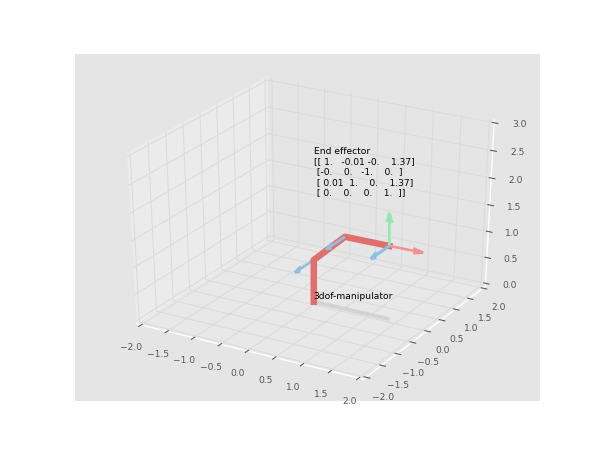

In [23]:
target = SE3(1.37 , 0 , 1.37)

link1 = RevoluteDH(d=0.8, a=0, alpha=np.pi/2)
link2 = RevoluteDH(d=0, a=0.8, alpha=0)
link3 = RevoluteDH(d=0, a=0.8, alpha=0)

my_bot = DHRobot([link1, link2, link3], name='3dof-manipulator')
my_bot.q = [0, np.pi/2, -np.pi/2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim3d(-2.0, 2.0)
ax.set_ylim3d(-2.0, 2.0)
ax.set_zlim3d(0.0, 3.0)

my_plot = RobotJupyterPlot(my_bot, ax, readonly=True)
my_plot.draw()


path_to_plot = inverse_kinematics(my_bot, target)

def init():
    my_plot.draw()
    return

def animate(i):
    if i < len(path_to_plot):
        my_bot.q = path_to_plot[i]
        my_plot.draw()
    return
    
ani = animation.FuncAnimation(fig, animate, frames=len(path_to_plot), blit=False, interval=100, init_func=init,
                              repeat=False)